# importing Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

from xgboost import XGBRegressor

# Data Loading

Sensor 1	Total temperature at fan inlet  
Sensor 2	Total temperature at LPC outlet         
Sensor 3	Total temperature at HPC outlet         
Sensor 4	Total temperature at LPT outlet         
Sensor 5	Pressure at fan inlet                   
Sensor 6	Total pressure in bypass-duct           
Sensor 7	Total pressure at HPC outlet            
Sensor 8	Physical fan speed          
Sensor 9	Physical core speed         
Sensor 10	Engine pressure ratio (P15/P2)          
Sensor 11	Static pressure at HPC outlet           
Sensor 12	Ratio of fuel flow to Ps30          
Sensor 13	Corrected fan speed         
Sensor 14	Corrected core speed            
Sensor 15	Bypass Ratio            
Sensor 16	Burner fuel-air ratio           
Sensor 17	Bleed Enthalpy          
Sensor 18	Required fan speed          
Sensor 19	Required fan conversion speed           
Sensor 20	High-pressure turbines Cool air flow            
Sensor 21	Low-pressure turbines Cool air flow         

In [2]:
cols = ['unit_number', 'time_in_cycle', 'operational_setting_1', 
        'operational_setting_2', 'operational_setting_3']
cols += [f"sensor{i}" for i in range(1, 22)]

train_path = "Turbofan_Engine_Degradation_Simulation_Dataset/CMAPSSData/train_FD001.txt"
test_path = "Turbofan_Engine_Degradation_Simulation_Dataset/CMAPSSData/test_FD001.txt"
RUL_path = "Turbofan_Engine_Degradation_Simulation_Dataset/CMAPSSData/RUL_FD001.txt"

train_df = pd.read_csv(train_path, sep='\s+', header=None, names=cols)
test_df = pd.read_csv(test_path, sep='\s+', header=None, names=cols)
y_test = pd.read_csv(RUL_path, sep='\s+', header=None, names=['RUL'])

train_df.head()

,unit_number,time_in_cycle,operational_setting_1,operational_setting_2,operational_setting_3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [3]:
print(f"train shape: {train_df.shape}")
print(f"test shape: {test_df.shape}")

train shape: (20631, 26)
test shape: (13096, 26)


In [4]:
train_df.describe()

,unit_number,time_in_cycle,operational_setting_1,operational_setting_2,operational_setting_3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,5.329200e-15,...,0.737553,0.071919,19.076176,0.037505,3.469531e-18,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [5]:
train_df.isnull().sum().sum()

np.int64(0)

# EDA

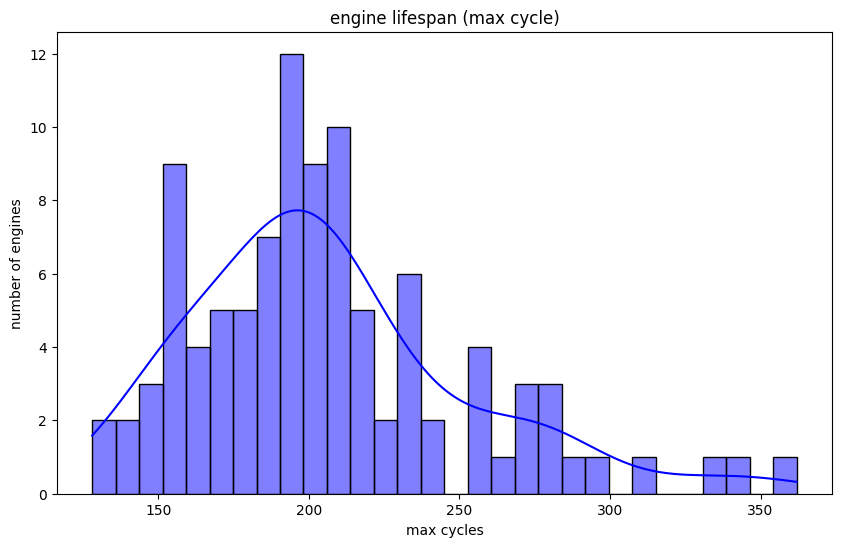

In [6]:
max_cycle = train_df.groupby('unit_number')['time_in_cycle'].max()

plt.figure(figsize=(10, 6))
sns.histplot(max_cycle, color='blue', bins=30, kde=True)
plt.title("engine lifespan (max cycle)")
plt.xlabel("max cycles")
plt.ylabel("number of engines")
plt.show()

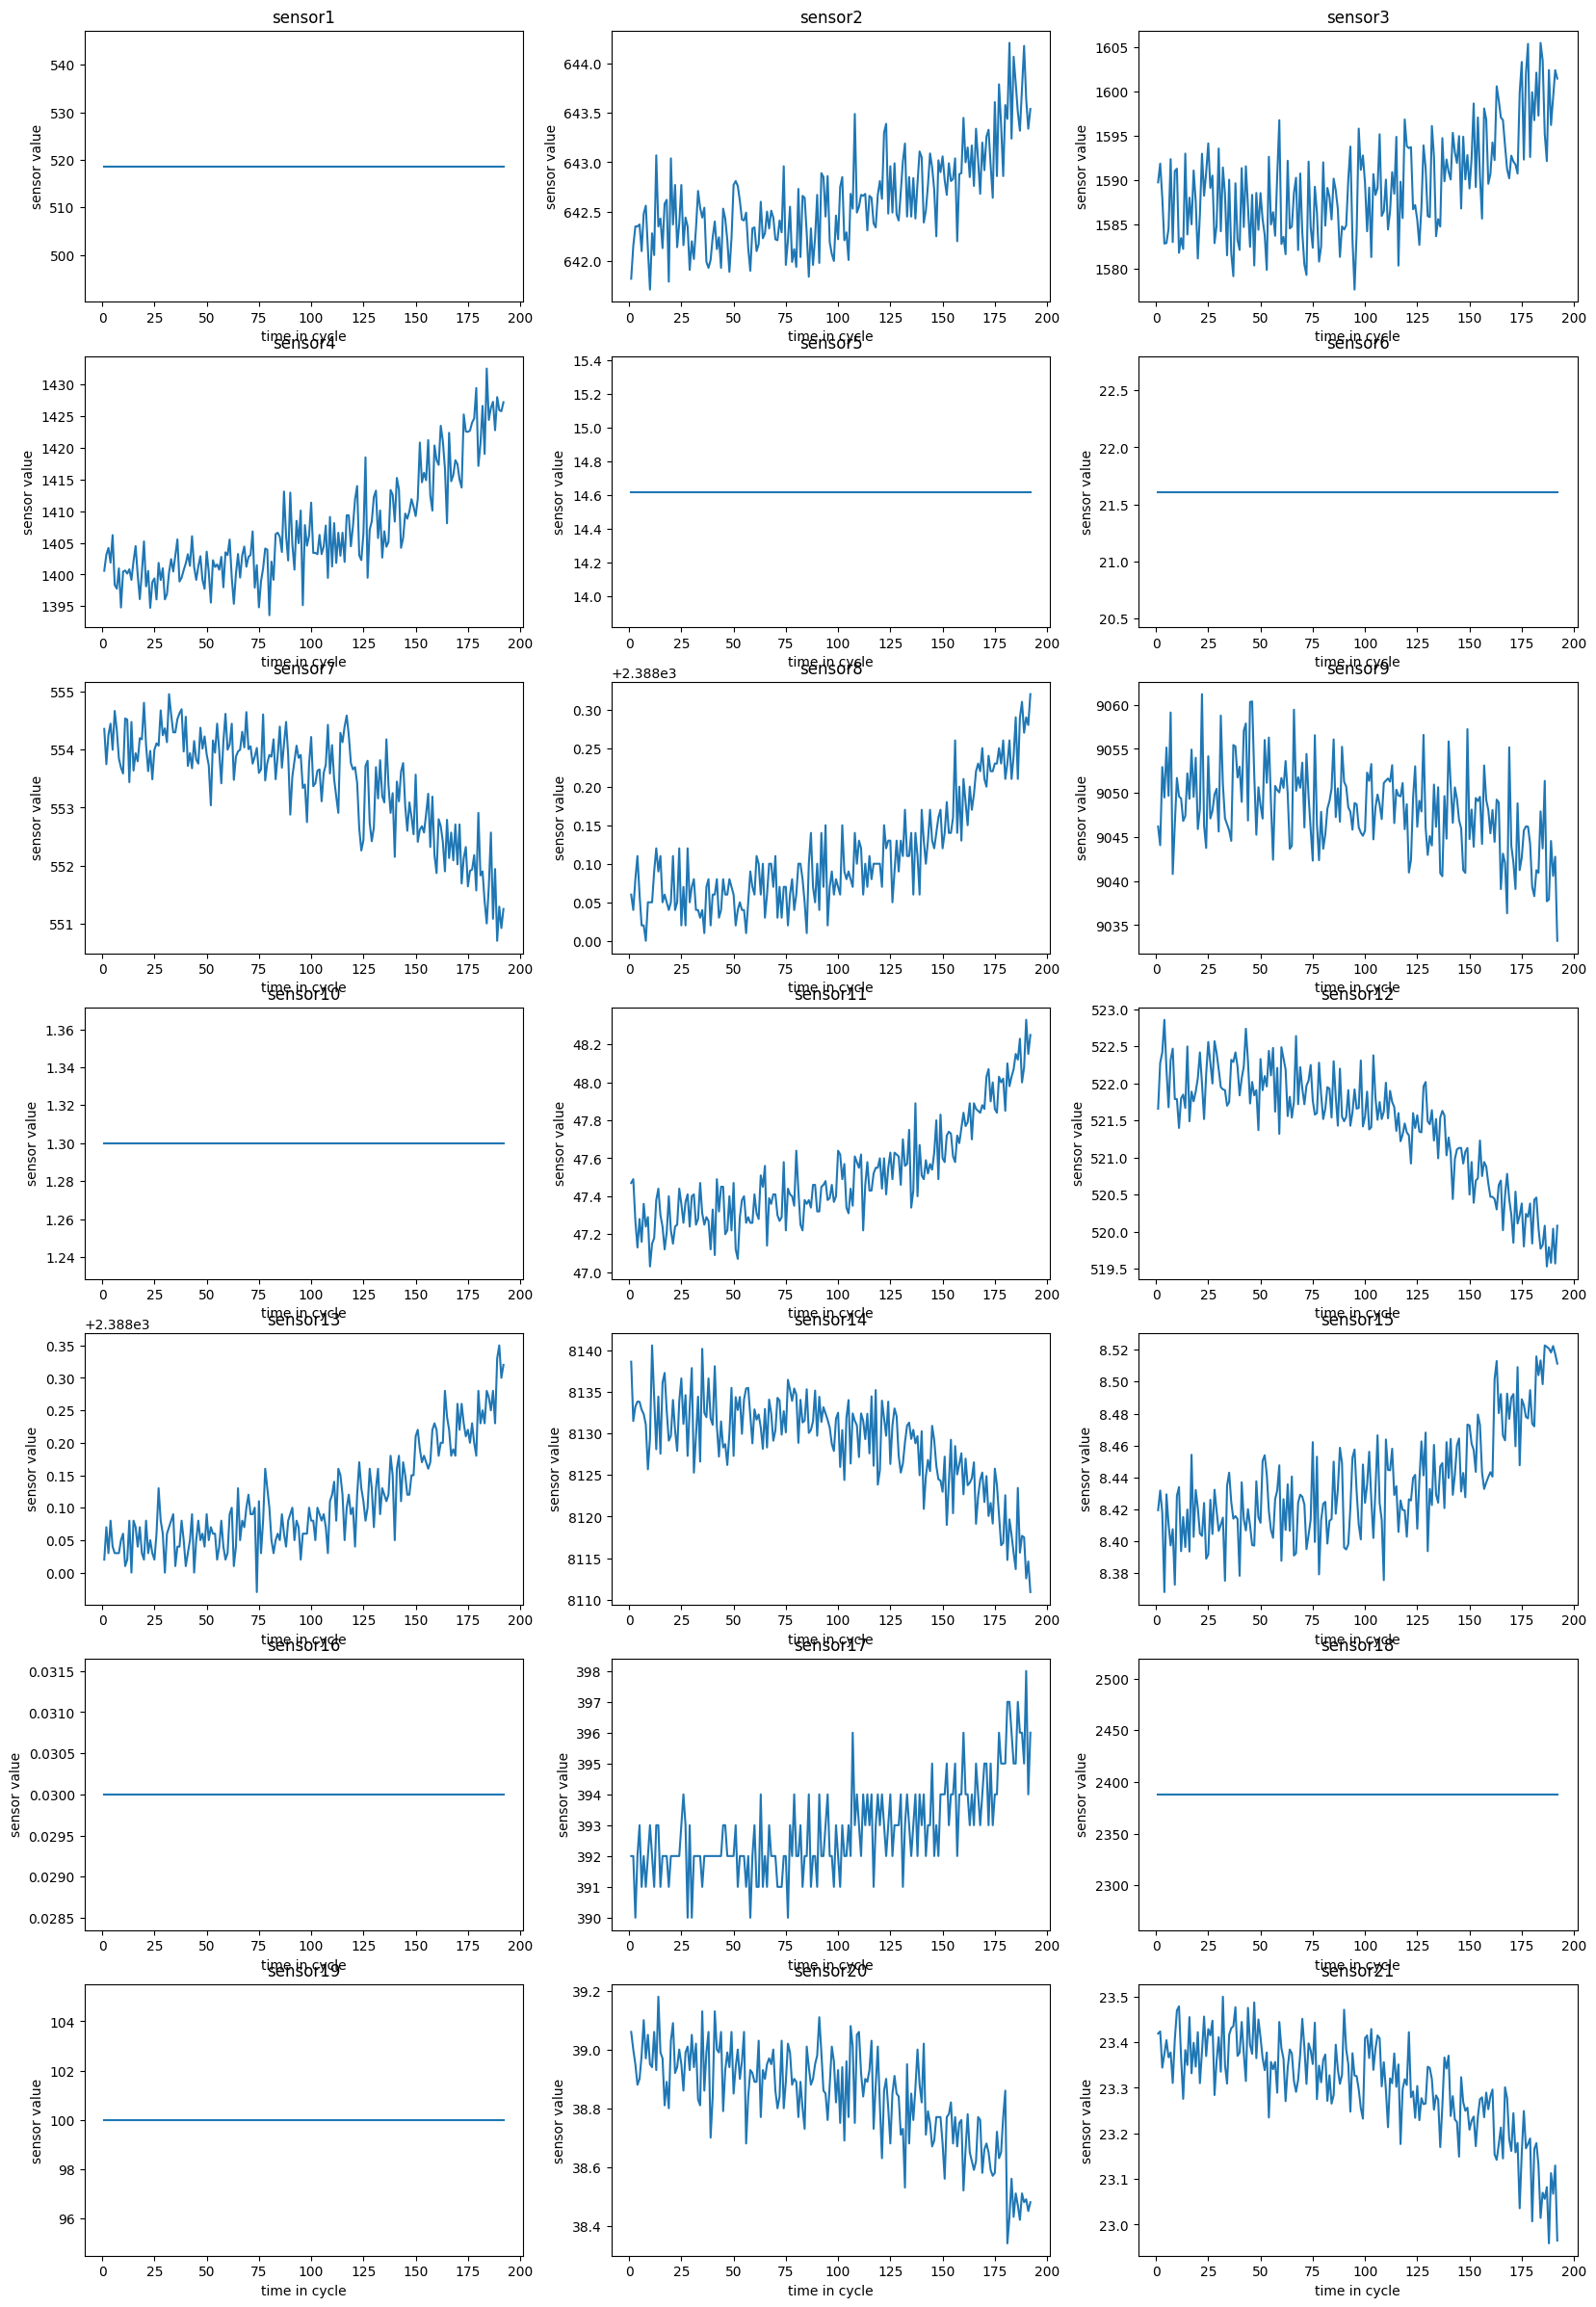

In [7]:
# sensors reaction to engine break ---> engine 1
plt.figure(figsize=(20, 30))
for i in range(1, 22):
    plt.subplot(7, 3, i)
    plt.plot(train_df[train_df['unit_number'] == 1]['time_in_cycle'], 
             train_df[train_df['unit_number'] == 1][f'sensor{i}'])
    plt.title(f'sensor{i}')
    plt.xlabel("time in cycle")
    plt.ylabel('sensor value')
plt.show()

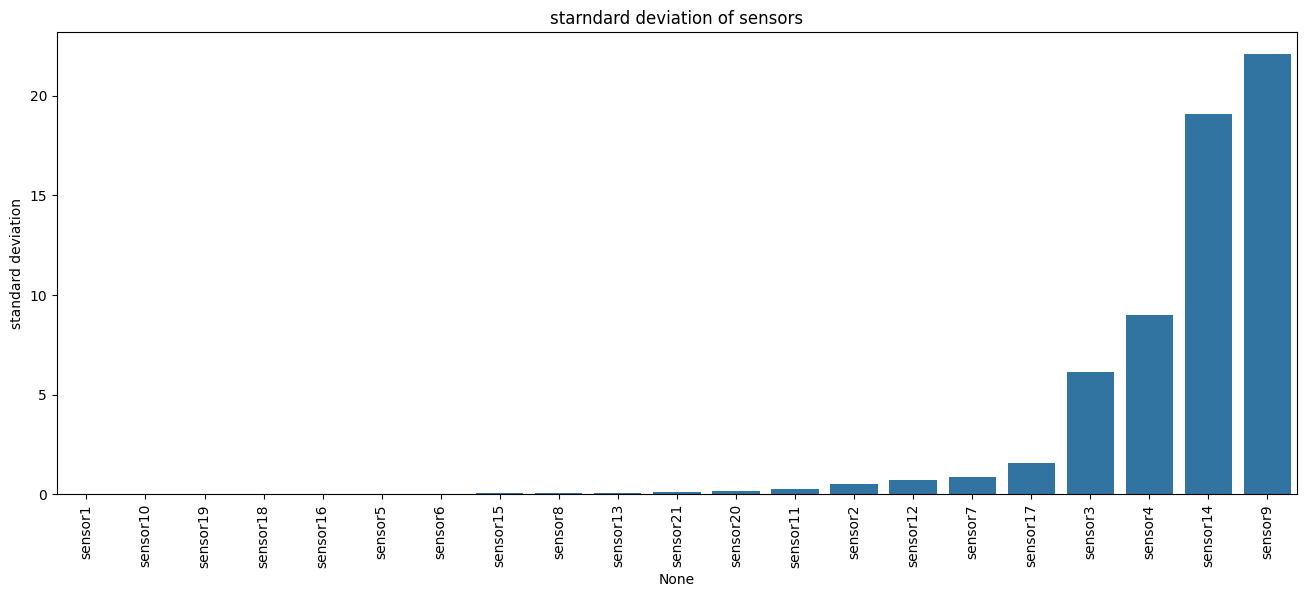

In [8]:
# we can already identify sensors with zero variance from the corr plot 
# but lets plot the standard deviation for each sensor
# we need to drop useless ones

sensor_std = train_df[[f"sensor{i}" for i in range(1, 22)]].std().sort_values()

plt.figure(figsize=(16, 6))
sns.barplot(x=sensor_std.index, y=sensor_std.values)
plt.title("starndard deviation of sensors")
plt.xticks(rotation=90)
plt.ylabel("standard deviation")
plt.show()

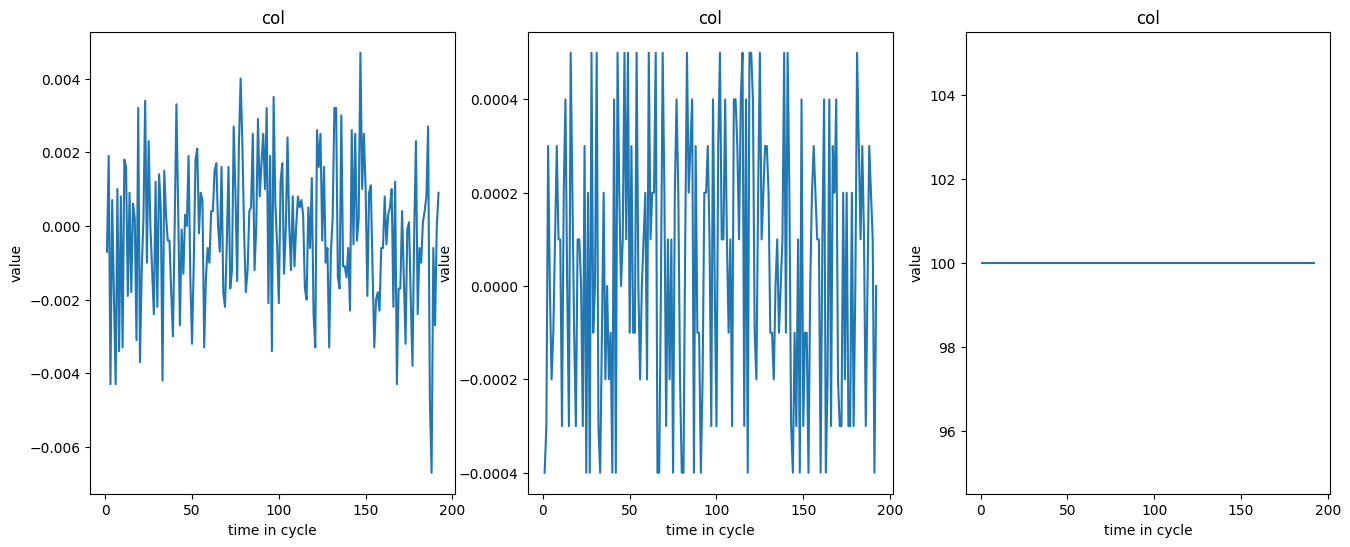

In [9]:
setting_cols = ['operational_setting_1', 'operational_setting_2', 'operational_setting_3']

plt.figure(figsize=(16, 6))
for i, col in enumerate(setting_cols):
    plt.subplot(1, 3, i+1)
    plt.plot(train_df[train_df['unit_number'] == 1]['time_in_cycle'],
             train_df[train_df['unit_number'] == 1][col])
    plt.title("col")
    plt.xlabel("time in cycle")
    plt.ylabel("value")
plt.show()

# Data Cleaning 

In [10]:
# we need to drop sensors with 0 variance or ALMOST 0 variance
# dropping sensros ----> 1, 5, 10, 16, 18, 19

sensors_to_drop = [f"sensor{i}" for i in (1, 5, 10, 16, 18, 19)]

train_df = train_df.drop(columns=sensors_to_drop)
test_df = test_df.drop(columns=sensors_to_drop)

train_df.shape

(20631, 20)

In [11]:
# cleaning setting cols
# setting 3 have 0 variance
# setting 1 and 2 have small variance which is probably noise 

train_df = train_df.drop(columns=setting_cols)
test_df = test_df.drop(columns=setting_cols)

train_df.shape

(20631, 17)

# Feature Engineering

In [12]:
# getting max cycle for each unit 
train_df['max_cycle'] = train_df.groupby('unit_number')['time_in_cycle'].transform('max')

In [13]:
# calculating cycles remaining (RUL)
train_df['RUL'] = train_df['max_cycle'] - train_df['time_in_cycle']

train_df.head()

,unit_number,time_in_cycle,sensor2,sensor3,sensor4,sensor6,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,max_cycle,RUL
0,1,1,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,192,191
1,1,2,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,192,190
2,1,3,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,192,189
3,1,4,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,192,188
4,1,5,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,192,187


# Preprocessing

In [14]:
X_train = train_df.drop(columns=['RUL', 'max_cycle', 'unit_number', 'time_in_cycle'])
y_train = train_df['RUL'].clip(upper=125)

X_test = test_df.groupby('unit_number').last().reset_index()
X_test = X_test.drop(columns=['unit_number', 'time_in_cycle'])

In [15]:
# scaling 
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
print(f"x train shape: {X_train_scaled.shape}")
print(f"x test shape: {X_test_scaled.shape}")
print(f"y train shape:  {y_train.shape}")
print(f"y test shape:  {y_test.shape}")

x train shape: (20631, 15)
x test shape: (100, 15)
y train shape:  (20631,)
y test shape:  (100, 1)


# Hyperparameter Search & Model Training

In [17]:
param_grid = {
    'n_estimators': [200, 300, 500, 700],  
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8, 10],               
    'subsample': [0.7, 0.8, 0.9, 1.0],           
    'colsample_bytree': [0.5, 0.7, 0.8, 0.9], 
    'gamma': [0, 0.1, 0.2] 
}

In [18]:
xgb_reg_model =XGBRegressor(
    objective='reg:squarederror',
    random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_reg_model,
    param_distributions=param_grid,
    n_iter=30,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1,
    random_state=42
).fit(X_train_scaled, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=4, n_estimators=700, subsample=0.9; total time=   4.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=4, n_estimators=700, subsample=0.9; total time=   4.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=4, n_estimators=700, subsample=0.9; total time=   1.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=4, n_estimators=700, subsample=0.9; total time=   1.7s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=4, n_estimators=700, subsample=0.9; total time=   1.4s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=8, n_estimators=500, subsample=0.7; total time=   8.7s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=8, n_estimators=500, subsample=0.7; total time=   9.4s
[CV] END colsample_bytree=0.8, gamma=0.2, learnin

# Model Evaluation

In [19]:
best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test_scaled)

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R2: {r2}")

RMSE: 17.81470489501953
R2: 0.816220223903656


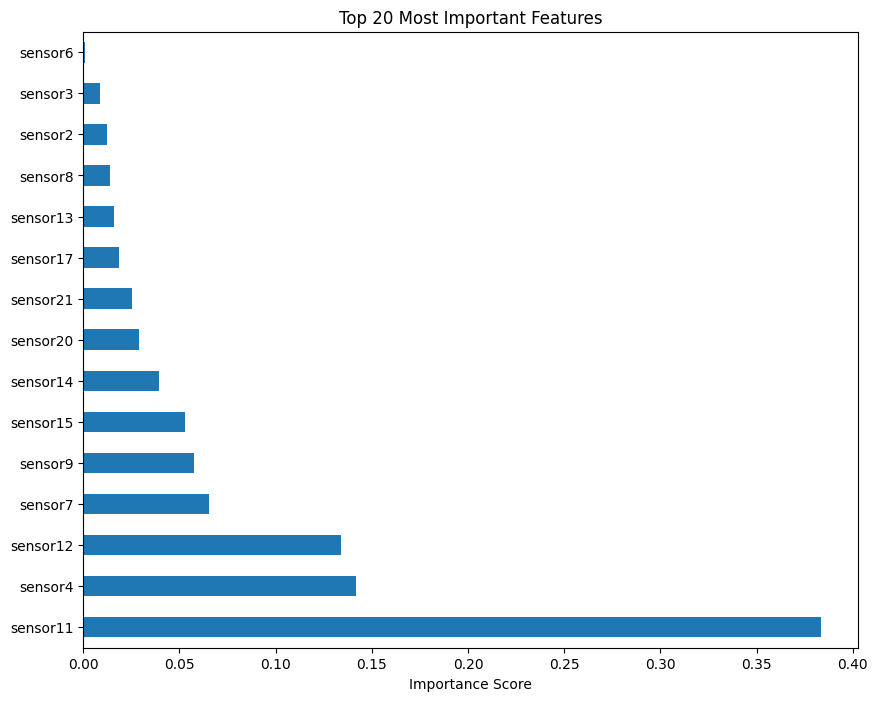

In [20]:
feature_names = X_train.columns
importances = best_model.feature_importances_ 
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# top 20 features
plt.figure(figsize=(10, 8))
feat_imp.head(20).plot(kind='barh')
plt.title("Top 20 Most Important Features")
plt.xlabel("Importance Score")
plt.show()